In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import matrix_rank
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras_preprocessing.sequence import TimeseriesGenerator 

Using TensorFlow backend.


In [2]:
df = pd.read_csv('data/Data.csv')
test_df = pd.read_csv('data/Test.csv')

In [3]:
# нет nan - хорошо, одной проблемой меньше
df.columns[df.isna().any()].tolist()

[]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18651 entries, 0 to 18650
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            18651 non-null  object 
 1   Bid_Price       18651 non-null  float64
 2   Bid_Shares      18651 non-null  int64  
 3   Ask_Price       18651 non-null  float64
 4   Ask_Shares      18651 non-null  int64  
 5   FeaturePrice1   18651 non-null  float64
 6   FeaturePrice2   18651 non-null  float64
 7   FeaturePrice3   18651 non-null  float64
 8   FeaturePrice4   18651 non-null  float64
 9   FeatureShares1  18651 non-null  int64  
 10  FeatureShares2  18651 non-null  int64  
 11  TargetPrice     18651 non-null  float64
dtypes: float64(7), int64(4), object(1)
memory usage: 1.7+ MB


In [5]:
# Показатели дисперсии указывают на большое количество outliers, на данном этапе неизвестно на сколько это большая проблема.
df.describe()

,Bid_Price,Bid_Shares,Ask_Price,Ask_Shares,FeaturePrice1,FeaturePrice2,FeaturePrice3,FeaturePrice4,FeatureShares1,FeatureShares2,TargetPrice
count,18651.000000,1.865100e+04,18651.000000,18651.000000,18651.000000,18651.000000,18651.000000,18651.000000,1.865100e+04,1.865100e+04,18651.000000
mean,49.808722,7.483422e+03,2769.878478,2715.718353,109.851994,109.834677,135.859794,51.318909,2.773807e+04,-2.133085e+03,50.633185
std,118.884831,1.129521e+05,22194.878283,16258.658494,3356.309019,3356.309296,3940.845536,143.405179,1.062102e+05,6.311341e+04,118.939909
min,0.000000,0.000000e+00,0.000000,0.000000,0.003500,0.000100,0.000000,0.004000,0.000000e+00,-2.398686e+06,0.003000
25%,4.990000,1.000000e+02,6.200000,100.000000,5.705000,5.700000,4.720000,5.745000,8.305000e+02,-3.622500e+03,5.695000
50%,20.500000,2.000000e+02,23.500000,200.000000,21.620000,21.590000,20.700000,21.670000,5.001000e+03,4.000000e+00,21.560000
75%,50.400000,9.380000e+02,54.625000,900.000000,51.290000,51.375000,51.430000,51.040000,1.850250e+04,2.367000e+03,51.045000
max,1437.000000,3.623700e+06,199999.990000,633852.000000,199999.990000,199999.990000,199999.990000,10855.660000,5.576209e+06,1.963809e+06,1435.000000


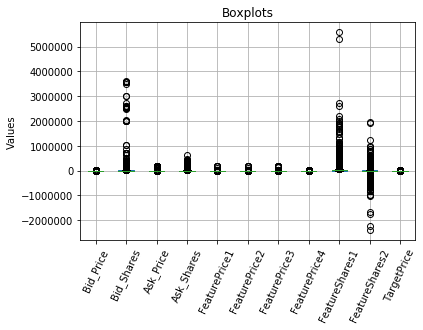

In [8]:
# Хорошо видны outliers в Bid_Shares, Feature_Shares1 и FeatureShares2. Интересно что только в FeatureShares2 имеет как позитивные так и негативные значения. Конечно же минус такого chart в том что y axis подстраивается под максимальные значения, поэтому кроме подтверждения наличия outliers информации немного.
df.boxplot(rot=65, fontsize=10)
plt.title('Boxplots')
plt.ylabel('Values')
plt.show()

## 1. Загрузка данных ##

* Одна из проблем заключается в том что на каждый торговый день приходится разное кол-во наблюдений. Решение которое я использовал - выбрать первые 100 наблюдений из каждого дня в хронологическом порядке. Таким образом каждый из 75-ти дней в X_train имеет 100 наблюдений.
Такое решение не является идеальным, более правильным было бы использовать padding, но на это уйдёт больше времени.

*  Также при создании train_test_split я распределил дни внутри выборок случайным образом. Это решение также спорное, оно следует из логики того что цель модели заключается в нахождении зависимостей в intra-day данных. Любые зависимости переходящие от одного дня к другому могут быть ложным сигналом и пропасть на более длительных промежутках времени.

In [9]:
def custom_train_test_split(df, date_col, num_rows, testing_frac):
    '''
    df - pandas.DataFrame
    date_col - str
    num_rows - int
    testing_frac - float
    
    Эта функция разбивает данные на тренеровочные и тестовые, и возвращает 100 первых наблюдений за каждый имеющийся   торговый день.
    '''
    
    np.random.seed(10)

    train = pd.DataFrame(columns=list(df.columns))
    test = pd.DataFrame(columns=list(df.columns))
    
    unique_days = np.unique(np.array(df[date_col])) 
    np.random.shuffle(unique_days) 
    train_fraction = round(len(unique_days)*testing_frac)

    for i in unique_days[:train_fraction]:
        partial_df = df.loc[df.Date == i][:num_rows]
        train = train.append(partial_df)

    for i in unique_days[train_fraction:]:
        partial_df = df.loc[df.Date == i][:num_rows]
        test = test.append(partial_df)
    
    train.reset_index(drop=True,inplace=True)
    test.reset_index(drop=True,inplace=True)

    return train[train.columns[:-1]],test[test.columns[:-1]], train[[train.columns[-1]]],test[[test.columns[-1]]]

In [34]:
X_train, X_test, y_train, y_test = custom_train_test_split(df, 'Date', 100, 0.7)

In [35]:
# Доказательство выполнения условия указанного в ТЗ, одинаковых дней в train и test выборках нет:

"""При обучении алгоритма важно, чтобы данные за любой выбранный день не попадали одновременно в тренировочную и тестовую выборки. Т.е. разбивать на тренировочную и тестовую выборки нужно не по строчкам данных, а по целым дням."""

set(np.array(X_train['Date'])).intersection(set(np.array(X_test['Date'])))

set()

In [36]:
# Простая визуализация любых из колонок с любым окном. 
def plot_data(df,column,start,stop):

    plt.plot(df[column][start:stop])
    plt.title(column)
    plt.xlabel('Time')

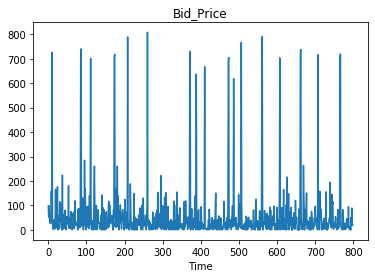

In [37]:
plot_data(X_train,'Bid_Price',0,799)

## 2. Pre-processing ##

На данном этапе из pre-processing делается только Standard Scaling для нормализации features идущих в модель.

In [ ]:
X_trainх

In [38]:
# Scaling
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train[X_train.columns[1:]]) # убираю "Date"
scaled_X_test = scaler.transform(X_test[X_test.columns[1:]]) # убираю "Date"

X_train = pd.DataFrame(scaled_X_train, columns=X_train.columns[1:])
X_test = pd.DataFrame(scaled_X_test, columns=X_test.columns[1:])

# Кореляционное поле
___

Исключая пары Bid_Price & Feature_Price4 и Feature_Price1 & Feature_Price2, кореляционное поле выглядит хорошо, multicollinearity не должен повлиять на тренеровку модели.

In [39]:
def load_test_set(df):
    """
    df - pandas.DataFrame

    Функция для загрузки test.csv повторяющая всю вышеуказанную подготовку данных.
    """

    new_df = pd.DataFrame(columns=list(df.columns))
    unique_days = np.unique(list(df.Date))

    for i in unique_days:
        partial_df = df.loc[df.Date==i][:100]
        new_df = new_df.append(partial_df)
    
    new_df.reset_index(drop=True, inplace=True)
    new_df = scaler.transform(new_df[new_df.columns[1:]])
    new_df = pd.DataFrame(new_df, columns=df.columns[1:])

    return new_df 

processed_test_df = load_test_set(test_df)

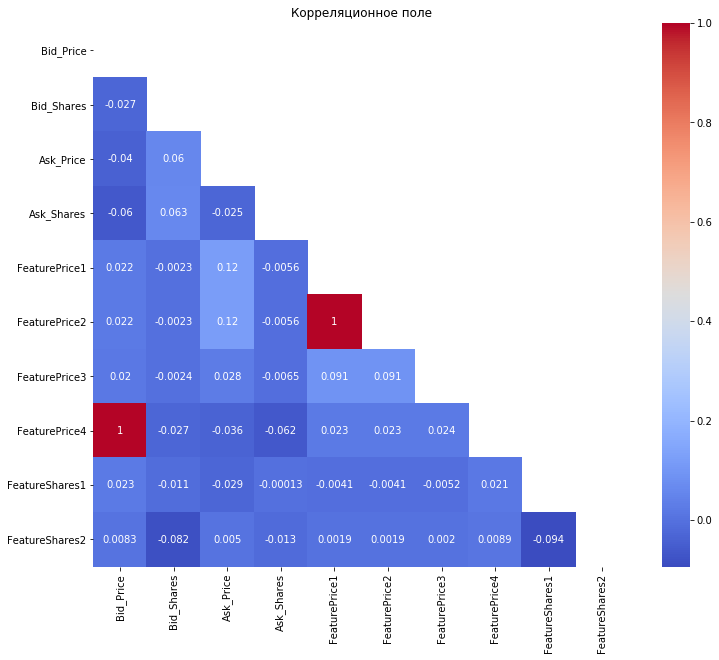

In [40]:
f, ax = plt.subplots(figsize=(12, 10))

matrix = np.triu(X_train.corr())
sns.heatmap(X_train.corr(), annot=True, mask=matrix, ax=ax, cmap= 'coolwarm')
ax.set_title('Корреляционное поле')
plt.show()

## 3. Подход к решению задачи ##

*Задание:*
Построить алгоритм прогнозирования значения цены в поле TargetPrice из Data.csv
по входящим данным:
Bid_Price
Bid_Shares...
___

*Подход:*

Предсказать каждую 4ю TargetPrice на основании 3х предыдущих  наблюдений которые включают в себя все features.
В результате для предсказания Target_Price (вектор длинной 1) используется вектор длинной 30, который включает в себя данные за три предыдущих наблюдения.

- Примечание #1: так как используется 30 параметра для прогонозирования одного $\tilde{y}_{i}$ существует overfit риск. Так как это задание экспериментальное я готов попробовать и посмотреть что получится.

In [42]:
def select_data_sequences(df,window_size,targets):

    """
    df - pandas.DataFrame
    window_size - int
    targets - pandas.DataFrame

    Данная функция готовит данные к применению вышеуказаной логики, разбивая данные на вектора-предсказатели и targets.
    """

    df_length = df.shape[0] # длинна df
    skip = window_size+1 # элемент индексирования для создания окна данных

###### создание индексов для выборки ######
    train_indexes,y_indexes = [],[]

    train_start, train_stop = 0, window_size
    target_start, target_stop = window_size, skip

    for i in range(int(df_length/skip)):

        train_range = np.arange(train_start, train_stop)
        train_indexes.append(train_range)
        train_start += skip
        train_stop += skip

        target_range = np.arange(target_start, target_stop)
        y_indexes.append(target_range)
        target_start += skip
        target_stop += skip

######  Подготовка данных для Keras ######        
    features = df.values[train_indexes]
    targets = targets.values[y_indexes]
    
    features = features.reshape(features.shape[0],-1)
    targets = targets.reshape(-1,targets.shape[1])
    
    features = np.reshape(features, (features.shape[0], 1, features.shape[1]))

    return features, targets

In [44]:
print(X_train.shape)
print(y_train.shape)

(1875, 1, 30)
(1875, 1)


In [45]:
# Выборка тестовых данных
X_test,y_test = select_data_sequences(X_test,3,y_test)

In [46]:
print(X_test.shape)
print(y_test.shape)

(800, 1, 30)
(800, 1)


In [43]:
# Выборка тренеровочных данных
X_train,y_train = select_data_sequences(X_train,3,y_train)

## Выбранные Модели ##

1.GradientBoostingRegressor - как правило XGBoost показывает лучшие результаты среди семьи алгоритмов из Scikit Learn, поэтому выбрал эту модель.

2.LSTM с помощью библиотеки Keras (быстрые прототипы), структура самой сети будет указана ниже. LSTM используется из-за своего дизайна направленного на работу с последовательными данными в том числе time-series. Также в я бы еще хотел  попровать 1d convolutional сеть, есть мнения о том что они работают лучше чем LSTM. Но пока что ограничусь только одним вариантом.
___
*Loss function:*
Так как задача регрессивная будут использоваться MSE и MAE. 

## XGBoost ##

In [47]:
# Функция select_data_sequences готовит данные для Keras, поэтому нужно сделать reshape для ScikitLearn.
X_train_skl = X_train.reshape(X_train.shape[0],X_train.shape[2])
X_test_skl = X_test.reshape(X_test.shape[0],X_test.shape[2])

In [48]:
xgb = GradientBoostingRegressor(loss='ls',learning_rate=0.9, n_estimators=100, criterion='mse')
xgb.fit(X_train_skl,y_train)
y_predicted = xgb.predict(X_train_skl)
error = mean_squared_error(y_train, y_predicted)

In [49]:
def plot_train_test_seq(model):
    """
    model - Scikitlearn model
    """
    train_prediction = model.predict(X_train_skl)
    test_prediction = model.predict(X_test_skl)
    
    train_error = mean_squared_error(y_train, train_prediction)
    test_error = mean_squared_error(y_test, test_prediction)

    print('train error {}'.format(train_error))
    print('test error {}'.format(test_error))

    fig, (ax1, ax2) = plt.subplots(2, sharex=False, figsize=(8,8))

    ax1.plot(y_train, label='Настоящие данные')
    ax1.plot(train_prediction,label='Смоделированные данные')
    ax1.set_title('Тренеровочные данные')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Price')
    ax1.legend()

    ax2.plot(y_test, label='Настоящие данные')
    ax2.plot(test_prediction,label='Смоделированные данные')
    ax2.set_title('Тестовые данные')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Price')
    ax2.legend()

    plt.tight_layout()
    plt.plot()

train error 534.7231539968687
test error 30972.696167211394


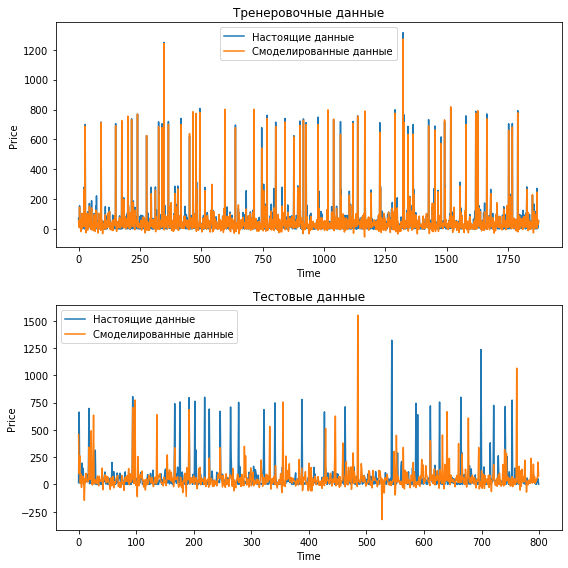

In [50]:
# Огромнейшая разница между train и test error, сильный overfit
plot_train_test_seq(xgb)

На тренеровочных данных XGBoost явно показал себя не плохо. Также модель предсказала отрицательные цены, что  явно не логично, несмотря на недавнюю ситуацию с фьючерсами на нефть.

## 4. Моделирование ##

Ожидания - сразу хочеться отметить что dataset очень маленький, поэтому адекватные результаты не ожидаются.

In [51]:
model = Sequential()
model.add(LSTM(100,return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1,activation='relu'))
model.compile(loss='mae', optimizer='RMSprop')

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 100)            52400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 82,651
Trainable params: 82,651
Non-trainable params: 0
_________________________________________________________________


## LSTM ##

Модель проста - 2 LSTM layers и один dense layer, за счёт маленького объёма данных я не думаю что модель что-то выучит,  она здесь больше как proof of concept.

Cross-Validation loss и epoch loss имеют относительно небольшую разницу, что  является хорошим признаком и говорит о том что модель действительно учит паттерны данных.

In [54]:
keras_predictions = model.predict(X_train)

## Комментарии к LSTM
За 10 эпох и с таким маленьким набором данных кончено-же модель ничего не выучила, нужно больше данных и эпох что бы понять адекватность этого метода. 

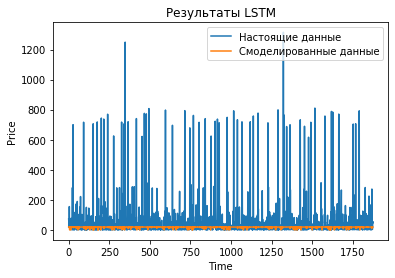

In [55]:
plt.plot(y_train,label='Настоящие данные')
plt.plot(keras_predictions,label='Смоделированные данные')
plt.title('Результаты LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [53]:
model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=2, shuffle=False, validation_split=0.33)

Train on 1256 samples, validate on 619 samples
Epoch 1/10
 - 3s - loss: 53.9981 - val_loss: 54.6430
Epoch 2/10
 - 1s - loss: 51.3989 - val_loss: 52.2178
Epoch 3/10
 - 1s - loss: 50.0213 - val_loss: 50.9367
Epoch 4/10
 - 1s - loss: 49.3856 - val_loss: 50.3607
Epoch 5/10
 - 1s - loss: 49.0372 - val_loss: 50.0478
Epoch 6/10
 - 1s - loss: 48.7556 - val_loss: 49.7385
Epoch 7/10
 - 1s - loss: 48.5436 - val_loss: 49.5676
Epoch 8/10
 - 1s - loss: 48.4713 - val_loss: 49.5073
Epoch 9/10
 - 1s - loss: 48.4368 - val_loss: 49.4646
Epoch 10/10
 - 1s - loss: 48.4102 - val_loss: 49.4306


## Выводы и дальнейшие действия: ##


Мой главный вывод:
В первую очередь я бы углубился в литературу по time series analysis и пробовал бы указаные методы. 
Недавно посоветовали: "Advances in Financial Machine Learning" by Marcos Lopez De Prado.
___

В связи с ограничением во времени анализ неполный и есть большой ряд процедур которые я бы хотел провести относительно подобного dataset. Остаются открытыми многие вопросы:

1. Pre-processing, это этап которому я уделил бы больше времени.
2. В контексте HFT (по моему предположению) outliers могут быть именно тем что нас интересуюет, поэтому не уверен что их нужно избегать.
3. Более углублённая работа с LSTM, анализ ошибок, усложнение структуры LSTM, и достаточное кол-во эпох.
4. Применение FFT.
5. Эксперимент с convolutional net.
6. PCA
7. Hyperparameter tuning
etc.

Спасибо за внимание !